In [1670]:
import spotipy 
import spotipy.util as util 
import os 
import pandas as pd

In [1671]:
username = os.environ.get('SPOTIFY_USERNAME')
Id = os.environ.get('SPOTIFY_CLIENT_ID')
secret = os.environ.get('SPOTIFY_CLIENT_SECRET')

In [1672]:
redirect_uri = 'https://unheard-login.com/callback/'

In [1673]:
#initialize Spotify API token 
#NOTE: assumes you have loaded Spotify credentials into user_config dict 

token = util.prompt_for_user_token(username=username,
                                   scope='playlist-modify-private', 
                                   client_id=Id, 
                                   client_secret=secret, 
                                   redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth=token)



In [1676]:
playlist_uri = 'spotify:playlist:6qd48xm5P7JXCxSdIQe4Ur'

In [1677]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [1678]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [1581]:
a,b,c,d = get_playlist_info(username, playlist_uri)

In [1625]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])

In [1626]:
df = get_features_for_playlist(df, username, playlist_uri)

In [1627]:
df.head()

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,An Encounter,The 1975,spotify:track:3Uuf7UQy96o8rkyEXSmAmv,0.8900,0.387,0.438,0.983000,0.0880,-16.424,0.0408,99.240,0.0567,New Playlist
1,TOOTIMETOOTIMETOOTIME,The 1975,spotify:track:33DzKnwuBE6lfOiADwzd5E,0.1770,0.667,0.824,0.015200,0.0933,-5.867,0.0665,114.998,0.5180,New Playlist
2,Runaround Sue,Dion,spotify:track:1DndHckdH9m5rp6gYP086b,0.4510,0.364,0.607,0.000000,0.2510,-9.791,0.1250,79.987,0.5980,New Playlist
3,What's My Age Again?,blink-182,spotify:track:4LJhJ6DQS7NwE7UKtvcM52,0.0126,0.391,0.951,0.000378,0.0878,-7.419,0.0692,157.660,0.4680,New Playlist
4,The Wanderer,Dion,spotify:track:3v8d3ku3kiTZVPxEt7a2dE,0.3010,0.590,0.546,0.000000,0.0936,-10.213,0.0436,114.040,0.8550,New Playlist


# Applying Principal Component Analysis(PCA)

In [1586]:
#Manuel Feature Extraction that provides little value 
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.8900,0.387,0.438,0.983000,0.0880,-16.424,0.0408,99.240,0.0567
1,0.1770,0.667,0.824,0.015200,0.0933,-5.867,0.0665,114.998,0.5180
2,0.4510,0.364,0.607,0.000000,0.2510,-9.791,0.1250,79.987,0.5980
3,0.0126,0.391,0.951,0.000378,0.0878,-7.419,0.0692,157.660,0.4680
4,0.3010,0.590,0.546,0.000000,0.0936,-10.213,0.0436,114.040,0.8550


In [1587]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [1588]:
x_std = scaler.fit_transform(df_X)

In [1589]:
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(x_std)

PCA()

In [1590]:
evr = pca.explained_variance_ratio_
evr

array([0.34896881, 0.16425152, 0.11889105, 0.09435694, 0.09182379,
       0.07847563, 0.04981466, 0.03714201, 0.01627558])

In [1591]:
#Explains: if we keep the minimum of 4 components we will still 
#able to explain 80% of the data
print(pca.explained_variance_ratio_.cumsum())

[0.34896881 0.51322033 0.63211138 0.72646831 0.81829211 0.89676774
 0.94658241 0.98372442 1.        ]


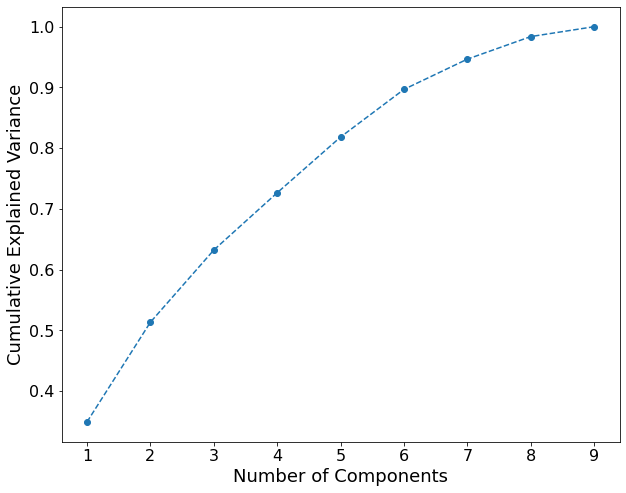

In [1592]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./Visualizations/cumulative_variance_plot.png")
plt.show()

In [1593]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.85:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(x_std)
scores_pca = pca.transform(x_std)

Number of components: 6


# K-Means Clustering 
Finding the elbow points of WCSS(within cluster sum of squares) curve using the YellowBrick KELblowVisualizer 

In [1594]:
from sklearn.cluster import KMeans

distortions = []

max_clusters = 12
#populating distortions for various clusters
#distoritions?? sum of squared distances of points from cluster centers 
for i in range(1,max_clusters): 
    kmeans = KMeans(i, random_state=25)
    kmeans.fit(scores_pca)
    distortions.append(kmeans.inertia_)

In [1595]:
from kneed import KneeLocator

n_clusters = KneeLocator([i for i in range(1, max_clusters)], distortions, curve='convex', direction='decreasing').knee
print("Optimal number of clusters:", n_clusters)

Optimal number of clusters: 5


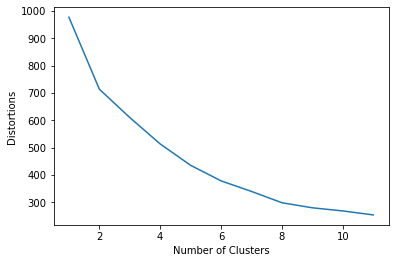

In [1596]:
import matplotlib.pyplot as plt 

plt.plot(range(1,12), distortions)
plt.xlabel('Number of Clusters')
plt.ylabel('Distortions')
plt.show()

In [1597]:
kmeans_pca = KMeans(n_clusters = n_clusters, init='k-means++', random_state=25)
kmeans_pca.fit(scores_pca)
df['Cluster'] = kmeans_pca.labels_

In [1598]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.8900,0.387,0.438,0.983000,0.0880,-16.424,0.0408,99.240,0.0567,5.168567,2.628291,-0.258598,3.777697,4.018558,1.408667,4
1,0.1770,0.667,0.824,0.015200,0.0933,-5.867,0.0665,114.998,0.5180,-1.075032,-0.836666,-0.002505,0.488766,0.485713,-0.711432,3
2,0.4510,0.364,0.607,0.000000,0.2510,-9.791,0.1250,79.987,0.5980,0.308269,0.628162,0.299226,1.334329,-1.489722,-0.297389,1
3,0.0126,0.391,0.951,0.000378,0.0878,-7.419,0.0692,157.660,0.4680,-1.419830,1.024098,-1.035880,-0.557153,0.460133,-0.228180,2
4,0.3010,0.590,0.546,0.000000,0.0936,-10.213,0.0436,114.040,0.8550,0.028394,-1.421681,-0.172105,0.126220,-0.079371,0.835485,3


/Users/estebanbarrios/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



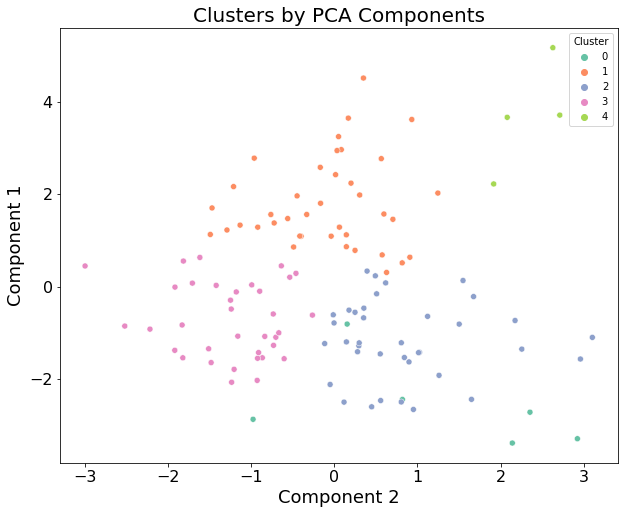

In [1599]:
import seaborn as sns
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette='Set2')
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [1600]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,An Encounter,The 1975,spotify:track:3Uuf7UQy96o8rkyEXSmAmv,0.8900,0.387,0.438,0.983000,0.0880,-16.424,0.0408,99.240,0.0567,New Playlist,4
1,TOOTIMETOOTIMETOOTIME,The 1975,spotify:track:33DzKnwuBE6lfOiADwzd5E,0.1770,0.667,0.824,0.015200,0.0933,-5.867,0.0665,114.998,0.5180,New Playlist,3
2,Runaround Sue,Dion,spotify:track:1DndHckdH9m5rp6gYP086b,0.4510,0.364,0.607,0.000000,0.2510,-9.791,0.1250,79.987,0.5980,New Playlist,1
3,What's My Age Again?,blink-182,spotify:track:4LJhJ6DQS7NwE7UKtvcM52,0.0126,0.391,0.951,0.000378,0.0878,-7.419,0.0692,157.660,0.4680,New Playlist,2
4,The Wanderer,Dion,spotify:track:3v8d3ku3kiTZVPxEt7a2dE,0.3010,0.590,0.546,0.000000,0.0936,-10.213,0.0436,114.040,0.8550,New Playlist,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Dancing Queen,ABBA,spotify:track:0GjEhVFGZW8afUYGChu3Rr,0.3580,0.543,0.870,0.000939,0.7920,-6.514,0.0428,100.804,0.7540,New Playlist,2
117,If It Wasn't For The Nights,ABBA,spotify:track:3R47KOuGuGvmoeQqbODPa3,0.2900,0.700,0.880,0.001860,0.2090,-4.692,0.0389,105.650,0.8720,New Playlist,3
118,Chiquitita,ABBA,spotify:track:762B4bOcXF7I2Y8UlKTyTy,0.7340,0.500,0.554,0.000004,0.3120,-8.108,0.0354,84.229,0.3720,New Playlist,1
119,Chiquitita - Spanish Version,ABBA,spotify:track:0Fuc8WMl8xSXjb8d4M6Xqo,0.5140,0.549,0.502,0.000000,0.2220,-9.110,0.0292,84.287,0.3980,New Playlist,1


In [1601]:
n_clusters

5

In [1613]:
songs = list(df.loc[df['Cluster'] == 2]['track_URI'])


#Making a new playlist with songs classified in a specific cluster 
for i in range(1):
    result = sp.user_playlist_create(username, 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    #songs = list(df.loc[df['Cluster'] == i]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)

In [67]:
df[df['Cluster'].isin([1])]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
3,Smoke on the Water,Deep Purple,spotify:track:5SAUIWdZ04OxYfJFDchC7S,0.09830,0.632,0.586,0.581000,0.0535,-11.333,0.0284,114.243,0.890,rock,1
11,Under the Bridge,Red Hot Chili Peppers,spotify:track:3d9DChrdc6BOeFsbrZ3Is0,0.05760,0.559,0.345,0.000105,0.1410,-13.496,0.0459,84.581,0.458,rock,1
14,Seven Nation Army,The White Stripes,spotify:track:7i6r9KotUPQg3ozKKgEPIN,0.00817,0.726,0.463,0.447000,0.2550,-7.828,0.0799,123.881,0.321,rock,1
31,Do I Wanna Know?,Arctic Monkeys,spotify:track:5FVd6KXrgO9B3JPmC8OPst,0.18600,0.548,0.532,0.000263,0.2170,-7.596,0.0323,85.030,0.405,rock,1
37,Will o the Wisp,Opeth,spotify:track:4kkPuJXecGNqHsaiCvdfmn,0.31800,0.452,0.386,0.002170,0.1500,-11.736,0.0260,63.344,0.250,rock,1
44,Friend of the Devil,Grateful Dead,spotify:track:5ZLzl6T8JwqMTMdoE0nCbU,0.33400,0.642,0.628,0.000008,0.6140,-12.849,0.0358,103.317,0.893,rock,1
45,Sunshine Of Your Love,Cream,spotify:track:6FRwDxXsvSasw0y2eDArsz,0.47500,0.684,0.481,0.000066,0.1180,-12.590,0.0384,115.078,0.784,rock,1
46,Stairway to Heaven - Remaster,Led Zeppelin,spotify:track:5CQ30WqJwcep0pYcV4AMNc,0.58000,0.338,0.340,0.003200,0.1160,-12.049,0.0339,82.433,0.197,rock,1
50,Gimme Shelter,The Rolling Stones,spotify:track:6H3kDe7CGoWYBabAeVWGiD,0.44700,0.634,0.630,0.039000,0.1700,-8.277,0.0310,118.628,0.489,rock,1
51,Life's Been Good,Joe Walsh,spotify:track:2wvMC5EyaaYQwBfiwwY2xE,0.25000,0.505,0.476,0.009150,0.1130,-12.897,0.0711,99.310,0.542,rock,1


In [1605]:
from sklearn.preprocessing import MinMaxScaler

def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,An Encounter,The 1975,spotify:track:3Uuf7UQy96o8rkyEXSmAmv,4,0.963203,0.328358,0.436529,1.000000,0.052702,0.166586,0.058256,0.227774,0.018168
1,TOOTIMETOOTIMETOOTIME,The 1975,spotify:track:33DzKnwuBE6lfOiADwzd5E,3,0.191557,0.746269,0.850027,0.015463,0.058595,0.808895,0.146846,0.344210,0.514083
2,Runaround Sue,Dion,spotify:track:1DndHckdH9m5rp6gYP086b,1,0.488094,0.294030,0.617568,0.000000,0.233934,0.570151,0.348501,0.085513,0.600086
3,What's My Age Again?,blink-182,spotify:track:4LJhJ6DQS7NwE7UKtvcM52,2,0.013635,0.334328,0.986074,0.000385,0.052479,0.714468,0.156153,0.659440,0.460331
4,The Wanderer,Dion,spotify:track:3v8d3ku3kiTZVPxEt7a2dE,3,0.325756,0.631343,0.552223,0.000000,0.058928,0.544476,0.067908,0.337131,0.876371


In [1606]:
from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["A", "D", "E", "I", "Li", "Lo", "S", "T", "V", "A"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Cluster " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        polar8=layoutdict,
        showlegend=True
        )
fig.show()

In [1607]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()

In [1610]:
df[df['Cluster']==3].iloc[:4]

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
1,TOOTIMETOOTIMETOOTIME,The 1975,spotify:track:33DzKnwuBE6lfOiADwzd5E,0.177,0.667,0.824,0.015200,0.0933,-5.867,0.0665,114.998,0.518,New Playlist,3
4,The Wanderer,Dion,spotify:track:3v8d3ku3kiTZVPxEt7a2dE,0.301,0.590,0.546,0.000000,0.0936,-10.213,0.0436,114.040,0.855,New Playlist,3
19,The Tracks Of My Tears - The Voice Performance,Chris Blue,spotify:track:70MbRTSwvwfdgCUPHcliBx,0.300,0.554,0.505,0.000000,0.0774,-6.293,0.0287,93.035,0.413,New Playlist,3
29,I Just Called To Say I Love You,Stevie Wonder,spotify:track:6RNDeRnWsRMjPdNVgupZCs,0.243,0.748,0.551,0.000002,0.0943,-9.054,0.0239,113.535,0.650,New Playlist,3


In [643]:
#Make the new playlist with the new songs that were recommended
#Making a new playlist with songs classified in the cluster 
for i in range(1):
    result = sp.user_playlist_create(username, 'Recommended Song based on Cluster 1:Attempt2' , public=True, collaborative=False, description='')
    playlist_id = result['id']
    songs = song['uri'].tolist()
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)